In [1]:
import os
import torch
import torchaudio
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import pandas as pd

import numpy as np 
import librosa

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [2]:
## Following is used to load our datasets into the Dataloader
def creating_data_loader(train_data, batch_size):
    train_dataloader = DataLoader(train_data, batch_size=batch_size)
    return train_dataloader


## Function used to train 1 epoch 
def train_one_epoch(our_model, data_loader, loss_fn, optimiser, device):
    print("Traininig")
    for inputs, target in data_loader:
    
        ## Ensure that our data is loaded to device
        target = target.type(torch.LongTensor)
        # print("target before", type(target))
        inputs = inputs.to(device)
        target = target.to(device)
        # print("target after", type(target))
        
        
        # calculating model loss
        prediction = our_model(inputs)
#         print("Our prediction is:", prediction, type(prediction))
#         print("Our target value is:", target, type(target))
        
        prediction = prediction.squeeze()
        # print("Modified prediction", prediction)
        loss = loss_fn(prediction, target)
        # print("Our loss is:", loss.item())

        # backpropagagation of error 
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    print(f"loss: {loss.item()}")
  
    

### Training multiple models 
def train(model, data_loader, loss_fn, optimiser, device, our_epochs, file_name):
    ## keep track of best model     
    best_valid_acc = 0.0
    evaluate_every_epoch = 1

    TRAINING_ACCURACY = {}
    VALIDATION_ACCURACY = {}
    for epoch in range(our_epochs):
        print(f"Epoch {epoch+1}")
        
        our_loss = train_one_epoch(model, data_loader, loss_fn, optimiser, device)
        print("---------------------------")
        
        
      
      # evaluate the network on the validation data
        if((epoch+1) % evaluate_every_epoch == 0):
            training_acc = full_evaluation(model, train_data)
            valid_acc = full_evaluation(model, valid_data)
            t_accuracy = {epoch:training_acc}
            v_accuracy = {epoch:valid_acc}
            TRAINING_ACCURACY.update(t_accuracy)
            VALIDATION_ACCURACY.update(v_accuracy)
            print('Validation accuracy: %g' % valid_acc)

            # if the best validation performance so far, save the network to file 
            if(best_valid_acc < valid_acc):
                best_valid_acc = valid_acc
                print(f'Saving best {file_name} model')
                torch.save(model.state_dict(), f'./best_{file_name}_model_for_vowel_classification')
    print()
    print("---------------------------")
    print("Finished training")
    return  TRAINING_ACCURACY, VALIDATION_ACCURACY


In [3]:

def single_evaluation(model, input, target):
    model.eval()
    with torch.no_grad():
        predictions = model(input).to('cpu')
        ## here we take the index with the highest value
        predicted_index = predictions[0].argmax(0).item()
        # print(predicted_index.item())
        # print(target)
    return predicted_index, int(target)
    

def full_evaluation(model,dataset):
    our_predictions = []
    our_target = []
    
    
    for i in range(len(dataset)):
       
        inputs, targets = dataset[i][0], dataset[i][1]
        inputs = inputs.unsqueeze_(0)
        ## call our single evaluation function and use recursivity to loop through all our inputs 
        pred, act = single_evaluation(model, inputs, targets)
        
        our_predictions.append(pred)
        our_target.append(act)

    print("Finished")
    ## evaluation of our output using accuracy score
    test_acc = accuracy_score(our_predictions, our_target)
    return test_acc


In [4]:
class VocalDataset(Dataset):

    def __init__(self,
                 binarylabelcsv,
                 audiofilefolder,
                 transformer,
                 target_sample_rate,
                 number_of_samples,
                 device):
        self.annotations_file = pd.read_csv(binarylabelcsv)
        self.audiofilefolder = audiofilefolder
        self.device = device
        ## our data is loaded to the device in order to use GPU or CPU 
        self.transformer = transformer.to(self.device)
        self.target_sample_rate = target_sample_rate
        self.number_of_samples = number_of_samples
    
    ## Used to check the length of our dataset 
    def __len__(self):
        return len(self.annotations_file)

    def __getitem__(self, index):
        
        audio_sample_path = self._get_file_path(index)
        label = self._get_label(index)
        ## load our audio
        signal, sr = torchaudio.load(audio_sample_path)
        signal = signal.to(self.device)
        signal = self._cut_length_if_required(signal)
     
        ## Convert the signal data into mel_spectogram
        signal = self.transformer(signal)
       
        return signal, label

 
    def _cut_length_if_required(self, signal):
        ## following ensures that our samples have the same shape
        if signal.shape[1] > self.number_of_samples:
            signal = signal[:, :self.number_of_samples]
        return signal


    def _get_label(self, index):
        ##  Read the specific annotations from the csv dataset
        ## 6 indicates to our target column or 'vowel_label_mapped' column 
        return self.annotations_file.iloc[index, 6]
    

    
    def _get_file_path(self, index):
        ## Our csv dataset contains the corresponding index for our particular task
        ## and 1 is the path file 'file_name_data'
        path = os.path.join(self.audiofilefolder,self.annotations_file.iloc[
            index, 1]+".wav")
        return path



In [5]:
class CnnNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=20,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=20,
                out_channels=40,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=40,
                out_channels=80,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.flatten = nn.Flatten()
        self.linear = nn.Linear(5040, 100)
        self.dropout = nn.Dropout(0.1)
        self.linear2 = nn.Linear(100, 5)
        ## softmax output layer 
        self.output = nn.Softmax(dim=1)


    def forward(self, input_data):
        # print("Input_shape",input_data.shape)
        x = self.conv1(input_data)
        # print("Conv 1",x.shape)
        x = self.conv2(x)
        # print("Conv 2",x.shape)
        x = self.conv3(x)
        # print("Conv 3",x.shape)
        x = self.flatten(x)
        # print("Flatten ",x.shape)
        x = self.linear(x)
        # print("Linear 1 1",x.shape)
        x = self.dropout(x)
         # print("Dropout 1",x.shape)
        
        x = self.linear2(x)
        # print("Linear 2",x.shape)
        

        ## softmax output layer
        finalpredictions = self.output(x)
        
        return finalpredictions




In [6]:
class ANNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        

        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.1)
        self.linear1 = nn.Linear(2816, 600)
        
        self.linear2 = nn.Linear(600, 100)
        self.linear3 = nn.Linear(100, 50)
        self.linear4 = nn.Linear(50,5)
       
        self.output = nn.Softmax(dim=1)

    def forward(self, input_data):
        # print("Input_shape",input_data.shape)
        
        x = self.flatten(input_data)
        # print("Flatten ",x.shape)
        x = self.linear1(x)
        x = self.dropout(x)
        # print("Linear 1 1",x.shape)
        x = self.linear2(x)
        x = self.dropout(x)
        # print("Linear 2",x.shape)
        x = self.linear3(x)
        x = self.dropout(x)
        # print("Linear 3",x.shape)
        x = self.linear4(x)
        # print("Linear 4",x.shape)
        
        final_prediction = self.output(x)
        # print("Output Layer:", final_prediction.shape)
        
        return final_prediction




In [7]:
if __name__ == "__main__":
    ## --------------- Initialising our variables.
    ## Using GPU
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    print(f"Using {device}")
    
    batch_size = 100
    our_epochs = 20
    learning_rate = 0.001
    sample_rate = 22050
    number_of_samples = 22050

    
    # creating desired mel spectogram 
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=1024,
        hop_length=512,
        n_mels=64)
   
    ## Path for our data 
    binarylabelcsv = os.path.expanduser('~/Deep Learning Audio /DL_Coursework/vocal_dataset.csv')
    audiofilefolder = os.path.expanduser("~/shared_storage/ECS7013P/data_by_vowel/")
    
    print("Loading Dataset")
    # device = 'cpu'
    data = VocalDataset(binarylabelcsv,
                       audiofilefolder,
                       mel_spectrogram,
                       sample_rate,
                       number_of_samples,
                       device)
    print("Example data value")
    signal, label = data[0]
    ## ---------------
    ### Initialise 
    print(f"We have  {len(data)} samples in our dataset.")
    print(signal.shape)
    print(signal)
    print(label)
    
    

    
    #### The following is used to split our dataset -----
   
    def creating_our_train_test_data(data,seed):
        #### The following is used to split our dataset -----
        train_all = round(len(data)*0.8)
        test_all = round(len(data)*0.2)

        train_valid_data, test_data = torch.utils.data.random_split(data, [train_all, test_all], generator=torch.Generator().manual_seed(seed))
        train_len = round(len(train_valid_data)*0.8)
        val_len = train_all - train_len

        print("test_data len:", val_len)
        train_data, valid_data = torch.utils.data.random_split(train_valid_data, [train_len, val_len], generator=torch.Generator().manual_seed(seed))

        print("train_data len:", len(train_data))
        print("valid_data len:", len(valid_data))
        print("test_data len:", len(test_data))
        #####   ----
        return train_data, valid_data, test_data
    
    
      
    train_data, valid_data, test_data = creating_our_train_test_data(data,10)
 
    #####   ----
    
    ### Training 
#   # constructing our  model and assigning to device either cpu or gpu 
    cnn = CnnNetwork().to(device)
    # # visualise our network 
    print(cnn)


    ## setting loss function 
    loss_fn = nn.CrossEntropyLoss()
    ## setting optimizer 
    optimiser = torch.optim.Adam(cnn.parameters(),
                                 lr=learning_rate)
    # train model
    # train_single_epoch(cnn, train_dataloader, loss_fn, optimiser, device)
    train_dataloader = creating_data_loader(train_data, batch_size)

    
    print("Length of our train_dataloader", len(train_dataloader))
    ## Example of training 1 epoch 
    # #train_one_epoch(cnn, train_dataloader, loss_fn, optimiser, device)
    

    ## Training and save best model in desired location
    print("Starting Training our CNN network")
    cnn_train_accuracy, cnn_val_accuracy =train(cnn, train_dataloader, loss_fn, optimiser, device, our_epochs, 'cnn')
    
    
    print("Finished training our CNN network")
    ann = ANNetwork().to(device)
    # # visualise our network 
    print(ann)

    ## setting optimizer 
    optimiser = torch.optim.Adam(ann.parameters(),
                                 lr=learning_rate)
    # train model

    print("Starting Training our ANN network")
#     ## Training and save best model in desired location
    ann_train_accuracy, ann_val_accuracy = train(ann, train_dataloader, loss_fn, optimiser, device, our_epochs, 'ann')
   
    print("Finished training our ANN network")






Using cuda
Loading Dataset
Example data value
We have  3442 samples in our dataset.
torch.Size([1, 64, 44])
tensor([[[1.1676e-02, 8.2902e-03, 1.6870e-02,  ..., 3.9305e-02,
          4.9815e-02, 2.6148e-01],
         [2.9888e-04, 1.6859e-03, 5.8703e-04,  ..., 9.1099e-03,
          1.0752e-02, 1.1565e+00],
         [3.6412e-06, 4.8589e-05, 6.0795e-04,  ..., 4.1969e+00,
          4.8081e+00, 7.9619e+00],
         ...,
         [2.2173e-04, 1.7561e-04, 2.0606e-04,  ..., 3.2157e-04,
          2.9273e-04, 4.9023e-04],
         [1.9601e-04, 2.4120e-04, 2.3794e-04,  ..., 3.8247e-04,
          3.8039e-04, 6.0534e-04],
         [3.5361e-04, 3.3849e-04, 2.1875e-04,  ..., 2.8031e-04,
          4.4690e-04, 3.5362e-04]]], device='cuda:0')
0
test_data len: 551
train_data len: 2203
valid_data len: 551
test_data len: 688
CnnNetwork(
  (conv1): Sequential(
    (0): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dila

In [8]:
## Function to plot the accuracy during epochs 
def plot_model_accuracy(train_accuracy, valid_accuracy):
    t_epochs = list(train_accuracy.keys())
    t_acc= list(train_accuracy.values())
    v_acc = list(valid_accuracy.values())
    plt.title('Training and Validation accuracy')
    plt.plot(t_epochs, t_acc, label ='training')
    plt.plot(t_epochs, v_acc,label='validation' )
    plt.legend(loc="upper right")
    plt.show()
    

Plot Training/Valid accuracy for ANN network


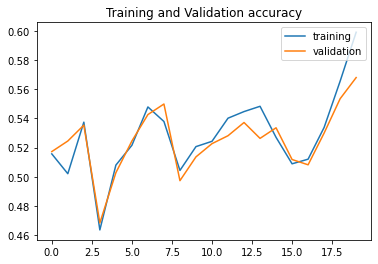

In [9]:
print("Plot Training/Valid accuracy for ANN network")
plot_model_accuracy(ann_train_accuracy, ann_val_accuracy)

Plot Training/Valid accuracy for CNN network


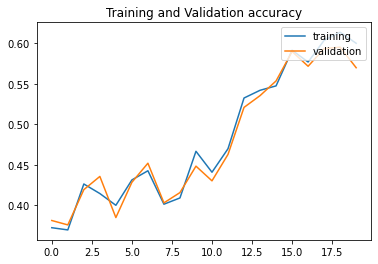

In [10]:
print("Plot Training/Valid accuracy for CNN network")


plot_model_accuracy(cnn_train_accuracy, cnn_val_accuracy)

In [11]:
# m = signal.unsqueeze_(0)
our_sample_signal = signal.squeeze(0).T.cpu().numpy()


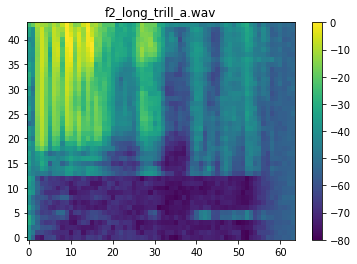

In [12]:
# # # MEl- spectogram sample example of 1
plt.title("f2_long_trill_a.wav")
plt.imshow(librosa.power_to_db(our_sample_signal, ref=np.max), aspect='auto', origin='lower')
plt.colorbar()
plt.show()


In [13]:
## Seperate function used to evaluate our test dataset and 
##  also to obtain a classification report and plot of Confusion Matrix 
def evaluating_test_dataset(model,dataset, our_class_mapping):
    our_predictions = []
    our_target = []
    class_mapping = our_class_mapping
    
    for i in range(len(dataset)):
       
        inputs, targets = dataset[i][0], dataset[i][1]
        inputs = inputs.unsqueeze_(0)
        pred, act = single_evaluation(model, inputs, targets)
        our_predictions.append(pred)
        our_target.append(act)

    print("Finished")
    test_acc = accuracy_score(our_predictions, our_target)
    
    report =classification_report(our_target, our_predictions, target_names=class_mapping)
    print('Accuracy is: %g' % test_acc)
    print('Classification Report : \n' , report)
    cm = confusion_matrix(our_target, our_predictions )
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_mapping)
    disp.plot()
    plt.show()
    return 



Evaluation of Test data using CNN network

Finished
Accuracy is: 0.543605
Classification Report : 
               precision    recall  f1-score   support

           a       0.60      0.69      0.64       122
           e       0.74      0.40      0.52       136
           i       0.40      0.59      0.48       139
           o       0.64      0.55      0.59       149
           u       0.52      0.51      0.51       142

    accuracy                           0.54       688
   macro avg       0.58      0.55      0.55       688
weighted avg       0.58      0.54      0.54       688



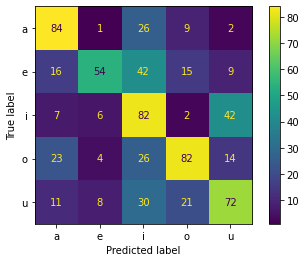

In [21]:
# ## evaluating our CNN model
network = CnnNetwork().to(device)
file_name = 'cnn'
state_dict = torch.load(f"best_{file_name}_model_for_vowel_classification")
network.load_state_dict(state_dict)

vowel_class_mapping = ['a', 'e', 'i', 'o', 'u'] 

print("Evaluation of Test data using CNN network") 
print()
evaluating_test_dataset(network,test_data, vowel_class_mapping)

## Can be used to obtain single evaluation 
## test_input, test_output = test_data[0]
## print(test_input.shape)
##single_evaluation(network, test_input.unsqueeze_(0), test_output)



Evaluation of Validation data CNN model
Finished
Accuracy is: 0.595281
Classification Report : 
               precision    recall  f1-score   support

           a       0.72      0.70      0.71       112
           e       0.84      0.50      0.63       112
           i       0.47      0.63      0.54       123
           o       0.60      0.57      0.58       100
           u       0.51      0.57      0.54       104

    accuracy                           0.60       551
   macro avg       0.63      0.59      0.60       551
weighted avg       0.63      0.60      0.60       551



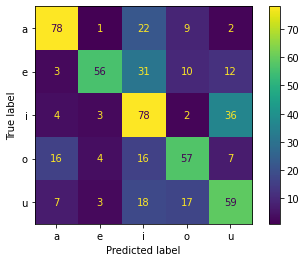

In [23]:
print("Evaluation of Validation data CNN model") 
evaluating_test_dataset(network,valid_data, vowel_class_mapping)

Evaluation of Test data using ANN network
Finished
Accuracy is: 0.524709
Classification Report : 
               precision    recall  f1-score   support

           a       0.41      0.83      0.55       122
           e       0.73      0.44      0.55       136
           i       0.55      0.60      0.58       139
           o       0.64      0.42      0.51       149
           u       0.49      0.37      0.42       142

    accuracy                           0.52       688
   macro avg       0.56      0.53      0.52       688
weighted avg       0.57      0.52      0.52       688



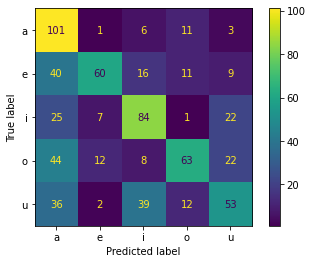

In [22]:
# ## evaluating our ANN model
network_2 = ANNetwork().to(device)
file_name = 'ann'
state_dict = torch.load(f"best_{file_name}_model_for_vowel_classification")

network_2.load_state_dict(state_dict)

print("Evaluation of Test data using ANN network") 

vocal_class_mapping = ['a', 'e', 'i', 'o', 'u']
evaluating_test_dataset(network_2,test_data, vowel_class_mapping)



## test_input, test_output = test_data[0]
## print(test_input.shape)
##single_evaluation(network_2, test_input.unsqueeze_(0), test_output)



Evaluation of Valid data using ANN network
Finished
Accuracy is: 0.568058
Classification Report : 
               precision    recall  f1-score   support

           a       0.51      0.87      0.64       112
           e       0.82      0.48      0.61       112
           i       0.56      0.55      0.56       123
           o       0.63      0.50      0.56       100
           u       0.47      0.42      0.44       104

    accuracy                           0.57       551
   macro avg       0.60      0.56      0.56       551
weighted avg       0.60      0.57      0.56       551



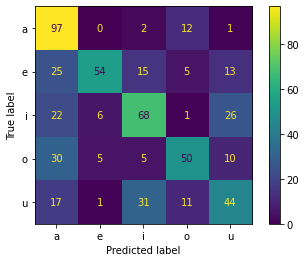

In [24]:
print("Evaluation of Valid data using ANN network") 

evaluating_test_dataset(network_2,valid_data, vowel_class_mapping)